# Neural style
### This is a simple refactoring of [Anish Athalye's neural style](https://github.com/anishathalye/neural-style)

In [1]:
import scipy.io
import numpy as np 
import os 
import scipy.misc 
import matplotlib.pyplot as plt 
import tensorflow as tf
%matplotlib inline  
print ("Packages loaded")

Packages loaded


# Define VGG

In [2]:
def net(data_path, input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )
    data = scipy.io.loadmat(data_path)
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0, 1))##对所有数据平均
    weights = data['layers'][0]
    net = {}
    current = input_image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current)
        net[name] = current
    assert len(net) == len(layers)
    return net, mean_pixel, layers
def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)
def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')
def preprocess(image, mean_pixel):
    return image - mean_pixel
def unprocess(image, mean_pixel):
    return image + mean_pixel
def imread(path):
    return scipy.misc.imread(path).astype(np.float)
def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)
print ("Network for VGG ready")

Network for VGG ready


# Extract features of a content image

C:\Users\Administrator\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


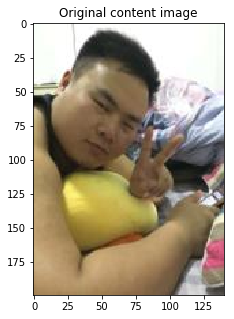

 Type of 'features' is  <class 'numpy.ndarray'>
 Shape of 'features' is (1, 100, 70, 128)


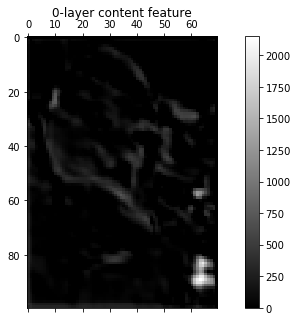

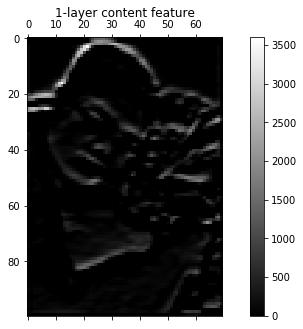

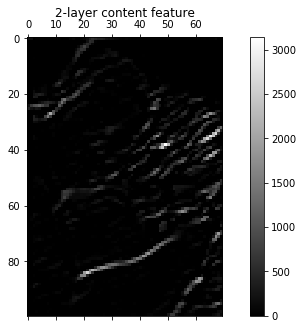

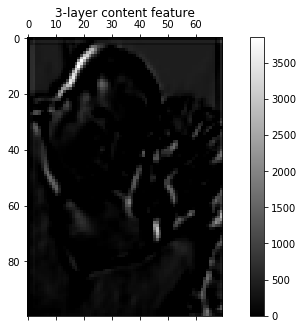

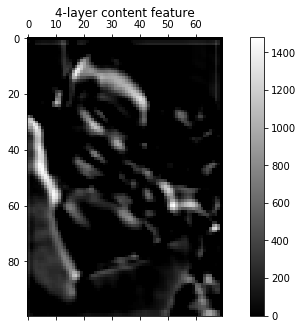

In [4]:
cwd           = os.getcwd()
VGG_PATH      = cwd + "/data/imagenet-vgg-verydeep-19.mat"
CONTENT_PATH  = cwd + "/images/zly1.jpg"
CONTENT_LAYER = 'relu2_2'
STYLE_LAYERS  = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')
# STYLE_LAYERS  = ('relu1_1', 'relu2_1')

raw_content = scipy.misc.imread(CONTENT_PATH)
plt.figure(0, figsize=(10, 5))
plt.imshow(raw_content)
plt.title("Original content image")
plt.show()

content_image = raw_content.astype(np.float)
content_shape = (1,) + content_image.shape # (h, w, nch) =>  (1, h, w, nch) 
with tf.Graph().as_default(), tf.Session() as sess:
    image = tf.placeholder('float', shape=content_shape)
    nets, content_mean_pixel, _ = net(VGG_PATH, image)
    content_image_pre = np.array([preprocess(content_image, content_mean_pixel)])
    content_features = nets[CONTENT_LAYER].eval(feed_dict={image: content_image_pre})
    print (" Type of 'features' is ", type(content_features))
    print (" Shape of 'features' is %s" % (content_features.shape,))
    # Plot response 
    for i in range(5):
        plt.figure(i, figsize=(10, 5))
        plt.matshow(content_features[0, :, :, i], cmap=plt.cm.gray, fignum=i)
        plt.title("%d-layer content feature" % (i))
        plt.colorbar()
        plt.show()

# Extract features of a style image

C:\Users\Administrator\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


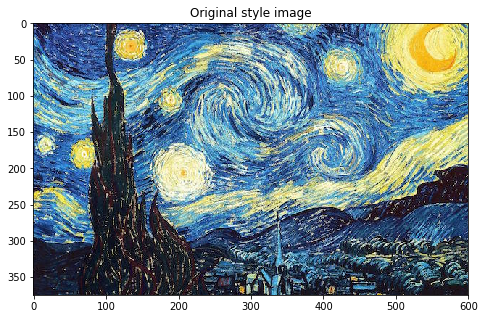

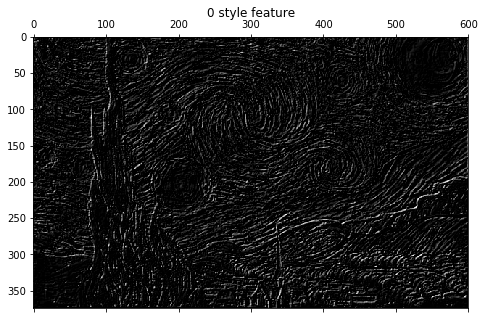

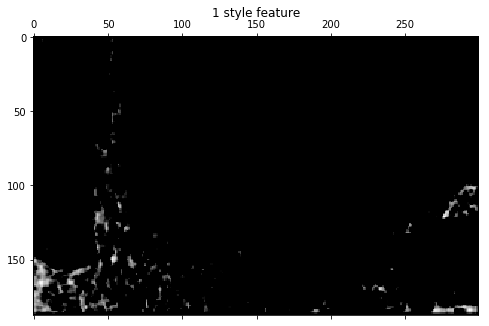

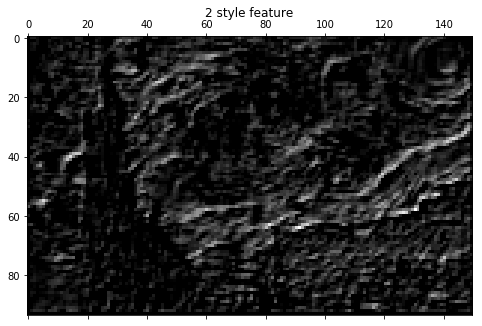

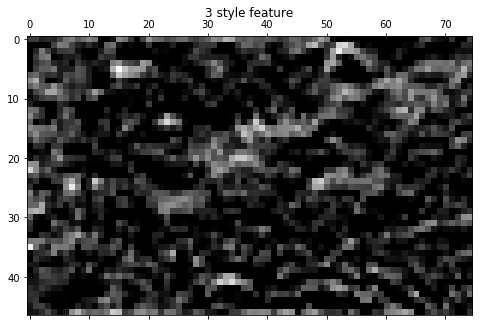

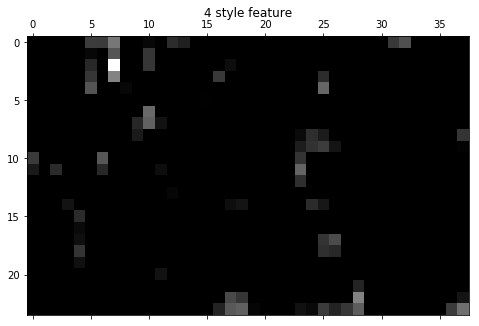

In [7]:
STYLE_PATH   = cwd + "/images/style2.jpg"
raw_style    = scipy.misc.imread(STYLE_PATH)

plt.figure(0, figsize=(10, 5))
plt.imshow(raw_style)
plt.title("Original style image")
plt.show()

style_image = raw_style.astype(np.float)
style_shape = (1,) + style_image.shape # (h, w, nch) =>  (1, h, w, nch) 
style_features = dict()
with tf.Graph().as_default(), tf.Session() as sess:
    image = tf.placeholder('float', shape=style_shape)
    nets, _, _ = net(VGG_PATH, image)
    style_image_pre = np.array([preprocess(style_image, content_mean_pixel)])
    for idx, layer in enumerate(STYLE_LAYERS):
        curr_features = nets[layer].eval(feed_dict={image: style_image_pre})
        curr_features_vec = np.reshape(curr_features, (-1, curr_features.shape[3]))
        gram = np.matmul(curr_features_vec.T, curr_features_vec) / curr_features_vec.size
        style_features.update({layer: gram})
        # Plot 
        plt.figure(idx, figsize=(10, 5))
        plt.matshow(curr_features[0, :, :, 0], cmap=plt.cm.gray, fignum=idx)
        plt.title("%d style feature" % (idx))
        plt.show()

# Optimize

[0/1000]


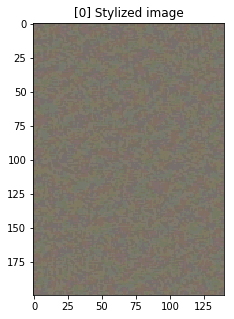

[100/1000]


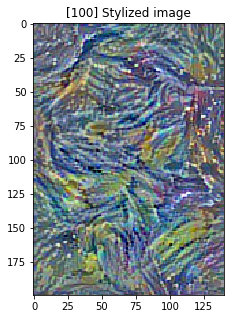

[200/1000]


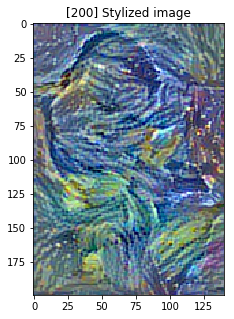

[300/1000]


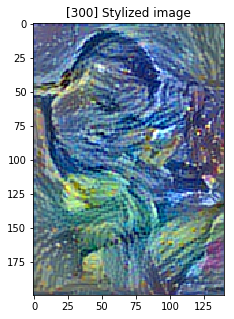

[400/1000]


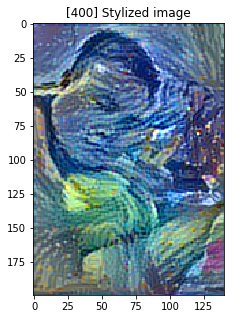

[500/1000]


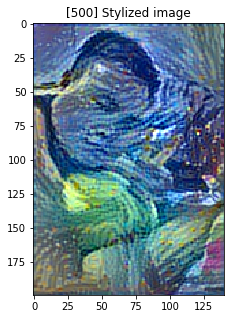

[600/1000]


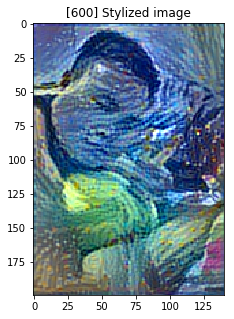

[700/1000]


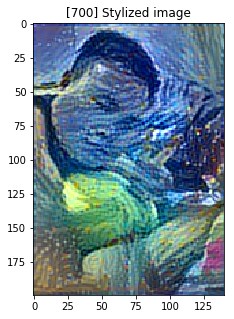

[800/1000]


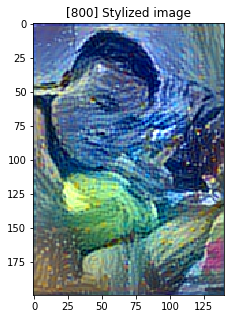

[900/1000]


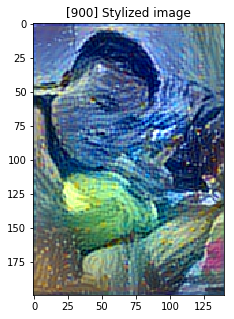

[999/1000]


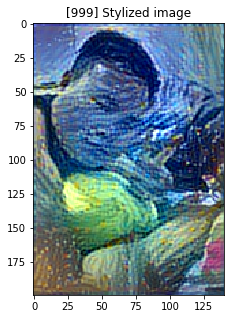

done

In [8]:
from functools import reduce
content_weight = 5 # 5 
style_weight   = 10 # 10
tv_weight      = 100 # 100
learning_rate  = 5.
iterations     = 1000
def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

with tf.Graph().as_default(), tf.Session() as sess:
    initial   = tf.random_normal(content_shape) * 0.256
    image2opt = tf.Variable(initial)
    nets, mean_pixel, _ = net(VGG_PATH, image2opt)
    
    # 1. content loss
    content_loss = content_weight * (2 * tf.nn.l2_loss(
        nets[CONTENT_LAYER] - content_features) / content_features.size)
    
    # 2. style loss
    style_losses = []
    for style_layer in STYLE_LAYERS:
        layer   = nets[style_layer]
        _, height, width, number = layer.get_shape()
        size    = height * width * number
        feats   = tf.reshape(layer, (-1, number.value))
        gram    = tf.matmul(tf.transpose(feats), feats) / size.value
        style_gram = style_features[style_layer]
        style_losses.append(2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
    style_loss = style_weight * reduce(tf.add, style_losses)
    
    # 3. Total variation denoising
    tv_y_size = _tensor_size(image2opt[:,1:,:,:])
    tv_x_size = _tensor_size(image2opt[:,:,1:,:])
    tv_loss = tv_weight * 2 * (
        (tf.nn.l2_loss(image2opt[:,1:,:,:] - image2opt[:,:content_shape[1]-1,:,:]) /
            tv_y_size) +
        (tf.nn.l2_loss(image2opt[:,:,1:,:] - image2opt[:,:,:content_shape[2]-1,:]) /
            tv_x_size))
    
    # Overall loss
    loss = content_loss + style_loss + tv_loss
    
    # optimizer setup
    optm = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    sess.run(tf.initialize_all_variables())
    for i in range(iterations):
        optm.run()
        if i % 100 == 0 or i == iterations-1:
            print ("[%d/%d]" % (i, iterations))
            out = image2opt.eval()
            # Plot
            stylized_img = out[0, :, :, :] + content_mean_pixel
            stylized_img = np.clip(stylized_img, 0, 255).astype('uint8')
            plt.figure(0, figsize=(10, 5))
            plt.imshow(stylized_img)
            plt.title("[%d] Stylized image" % (i))
            plt.show()
    out = image2opt.eval()
print ("done")

# Plot final image

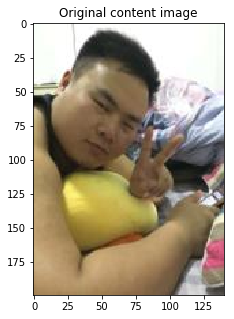

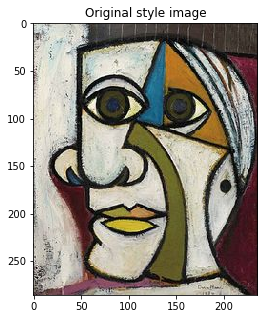

In [8]:
plt.figure(0, figsize=(10, 5))
plt.imshow(raw_content)
plt.title("Original content image")
plt.show()

plt.figure(0, figsize=(10, 5))
plt.imshow(raw_style)
plt.title("Original style image")
plt.show()

stylized_img = out[0, :, :, :] + content_mean_pixel
stylized_img = np.clip(stylized_img, 0, 255).astype('uint8')
plt.figure(1, figsize=(10, 5))
plt.imshow(stylized_img)
plt.title("Stylized image")
plt.show()